## Setup, Installations, and Imports

In [ ]:
#install packages as necessary
!pip -q install accelerate datasets transformers evaluate jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 6.6 MB/s eta 0:00:00


In [ ]:
#import our packages
import torch
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from datasets import load_metric
from transformers import AutoImageProcessor, AutoModelForImageClassification, Trainer, TrainingArguments, BlipProcessor, BlipForConditionalGeneration
import matplotlib.pyplot as plt
import accelerate
import numpy as np
import pickle
import random
import tqdm
import requests
import evaluate
from PIL import Image
import copy

In [ ]:
#mount the drive (for saving files to google drive (so the data will not have to be reprocessed everytime colab restarts a session))
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Data Extraction and Preprocessing

In [ ]:
#for the specific cell block right below this one: it is taken from the original paper that created the raw dataset we're using.
#it's been modified/adapted for our use case but credit goes to that paper and its authors. It provides some processing of bekrn files
#that has been helpful for our group, since we are not familiar with the notation or the predecessor notation it was based on

In [ ]:
# import gin
import os
import cv2
import torch

from rich.progress import track
from torch.utils.data import Dataset
from torchvision import transforms

def load_data(partition_file, resize_ratio=1., use_raw_krn=False, load_distorted=False, extension=".bekrn"):
    X = []
    Y = []
    with open(partition_file) as partfile:
        part_lines = partfile.read()
        part_lines = part_lines.split("\n")
        # print(part_lines)
        for file_path in track(part_lines, description="Loading..."):
            if extension != ".bekrn":
                file_path = file_path.replace(".bekrn", extension)
            krn = None
            krnlines = []
            file_path = f"{file_path}"
            # print(file_path)
            if os.path.isfile(file_path):
                with open(file_path) as krnfile:
                    try:
                      krn = krnfile.read()
                    except:
                      continue
                    krn = krn.replace(" ", " <s> ")
                    krn = krn.replace("·", " ")
                    lines = krn.split("\n")
                    for line in lines:
                        line = line.replace("\t", " <t> ")
                        line = line.split(" ")
                        if len(line) > 1:
                            line.append("<b>")
                            krnlines.append(line)
                    # print(os.path.exists(f"{file_path.split('.')[0]}.jpg"))
                    if os.path.exists(f"{file_path.split('.')[0]}.jpg"):
                        # print("HELLO")
                        if load_distorted:
                            height = 256
                            img = cv2.imread(f"{file_path.split('.')[0]}_distorted.jpg", 0)
                            width = int(float(height * img.shape[1]) / img.shape[0])
                            img =  cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
                            if (height//8) * (width//16) > len(sum(krnlines, [])):
                                width = int(np.ceil(img.shape[1] * resize_ratio))
                                height = int(np.ceil(img.shape[0] * resize_ratio))
                                img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
                                img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                                X.append(img)
                                Y.append(sum(krnlines, []))
                        else:
                            img = cv2.imread(f"{file_path.split('.')[0]}.jpg", 0)
                            width = int(np.ceil(img.shape[1] * resize_ratio))
                            height = int(np.ceil(img.shape[0] * resize_ratio))
                            img = cv2.resize(img, (width, height), interpolation=cv2.INTER_LINEAR)
                            img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                            X.append(img)
                            Y.append(sum(krnlines, []))
            # print(len(X))
            # print(len(krnlines))
    print(len(X)), print(len(Y))
    return X, Y


class PoliphonicDataset(Dataset):
    def __init__(self, partition_file) -> None:
        self.x, self.y = load_data(partition_file)
        self.tensorTransform = transforms.ToTensor()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        image = self.tensorTransform(self.x[index])
        gt = torch.from_numpy(np.asarray([self.w2i[token] for token in self.y[index]]))

        return image, gt, (image.shape[2] // 8) * (image.shape[1] // 16), len(gt)

    def get_max_hw(self):
        m_width = np.max([img.shape[1] for img in self.x])
        m_height = np.max([img.shape[0] for img in self.x])

        return m_height, m_width

    def get_max_seqlen(self):
        return np.max([len(seq) for seq in self.y])

    def vocab_size(self):
        return len(self.w2i)

    def get_gt(self):
        return self.y

    def set_dictionaries(self, w2i, i2w):
        self.w2i = w2i
        self.i2w = i2w
        self.padding_token = w2i['<pad>']

    def get_dictionaries(self):
        return self.w2i, self.i2w

    def get_i2w(self):
        return self.i2w

In [ ]:
'''
Note: This section is just meant to extract the data from the original tgz file, process it into a Dataset object, and save it accordingly (such that it can persist beyond individual Google Colab sessions)
If all of the above has already been done, skip this section.
'''

'\nNote: This section is just meant to extract the data from the original tgz file, process it into a Dataset object, and save it accordingly (such that it can persist beyond individual Google Colab sessions)\nIf all of the above has already been done, skip this section.\n'

In [ ]:
#unzip the tgz raw data file.
#note: change the below string paths as appropriate.

!tar -xzf "grandstaff.tgz" -C "grandstaff_dataset/"

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.lastuseddate#PS'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.apple.quarantine'
tar: Ignoring unknown extende

In [ ]:
##note: below is only meant to be run if the dataset has not been previously created and saved

#Set up the train, val, and test sets as Dataset objects
train_path = "drive/MyDrive/train_shuffled.txt"
val_path = "drive/MyDrive/val_shuffled.txt"
test_path = "drive/MyDrive/test_shuffled.txt"

#create the PoliphonicDataset objects
train_dataset = PoliphonicDataset(partition_file=train_path)
val_dataset = PoliphonicDataset(partition_file=val_path)
test_dataset = PoliphonicDataset(partition_file=test_path)

# #save the Dataset objects to your google drive so they can persist between sessions.
with open('drive/MyDrive/val_poliphonic.pickle', 'wb') as output:
    pickle.dump(val_dataset, output)
with open('drive/MyDrive/train_poliphonic.pickle', 'wb') as output:
    pickle.dump(train_dataset, output)
with open('drive/MyDrive/test_poliphonic.pickle', 'wb') as output:
    pickle.dump(test_dataset, output)


In [ ]:
##note: only run the below if the poliphonic dataset has already been saved and can be read in from path below.
with open('drive/MyDrive/val_poliphonic.pickle', 'rb') as output:
    val_dataset = pickle.load(output)
with open('drive/MyDrive/train_poliphonic.pickle', 'rb') as output:
    train_dataset = pickle.load(output)
with open('drive/MyDrive/test_poliphonic.pickle', 'rb') as output:
    test_dataset = pickle.load(output)

In [ ]:
#double check that the lengths of the datasets we just read in are as expected
len(train_dataset), len(test_dataset), len(val_dataset)

(32330, 10776, 10776)

In [ ]:
# def make_vocabulary(YSequences: list[list]):
#   '''
#   Creates the mapping between the model output and human-interpretable labels.

#   Args:
#     YSequences (list): the list of ground-truth label sets
#   Returns:
#     tuple(dict): the mapping from labels to ids and ids to labels, respectively.
#   '''
#   vocabulary = set()
#   for samples in YSequences:
#       for element in samples:
#               vocabulary.update(element)

#   #Vocabulary created
#   w2i = {symbol:idx+1 for idx,symbol in enumerate(vocabulary)}
#   i2w = {idx+1:symbol for idx,symbol in enumerate(vocabulary)}

#   w2i['<pad>'] = 0
#   i2w[0] = '<pad>'

#   return w2i, i2w

In [ ]:
# #set up our id -> labels and labels -> id maps
# w2i, i2w = make_vocabulary([train_dataset.get_gt(), val_dataset.get_gt(), test_dataset.get_gt()])

In [ ]:
# #check the max length of labels across all samples (this will be the max_length to which we pad later on)
# def maxpad_length(list_of_lists):

#   local_maxes = []
#   for lst in list_of_lists:
#     local_maxes.append(max([len(ele) for ele in lst.get_gt()]))

#   return max(local_maxes)

# max_length = maxpad_length([train_dataset, val_dataset, test_dataset])
# print(max_length)

In [ ]:
# #set the dictionaries for each of the datasets
# train_dataset.set_dictionaries(w2i, i2w)
# val_dataset.set_dictionaries(w2i, i2w)
# test_dataset.set_dictionaries(w2i, i2w)

## Create the train, test, and val files

In [ ]:
'''
Note: This section is only for denominating which samples will go into train vs test vs val datasets. If that's already been determined by some other method,
skip this section.
'''

In [ ]:
#let's get the total number of samples from the dataset first
import os

sample_bekrn = [] #here, we're only interested in the bekern files (vs the krn files)

for root, dirs, files in os.walk("grandstaff_dataset/"):
   for name in files:
      if 'bekrn' in name:
        print(os.path.join(root, name))
        sample_bekrn.append(os.path.join(root, name))

Streaming output truncated to the last 5000 lines.
grandstaff_dataset/chopin/mazurkas/mazurka33-2/min3_up_m-16-20.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/maj2_down_m-8-12.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/min3_down_m-84-87.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/min3_down_m-21-24.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/maj2_up_m-18-21.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/maj3_down_m-85-90.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/min3_down_m-126-129.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/maj2_down_m-116-120.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/min3_down_m-96-99.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/maj3_up_m-128-132.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/maj2_up_m-54-57.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/min3_down_m-30-33.bekrn
grandstaff_dataset/chopin/mazurkas/mazurka33-2/original_m-128-132.bekrn
grandstaff_dataset/chopin/ma

In [ ]:
len(sample_bekrn)

53889

In [ ]:
#let's split the train-val-test sets such that each are 60%, 20%, and 20% of all the samples we have
train_pt, val_pt = 53889*0.6, 53889*0.8
train_pt, val_pt

(32333.399999999998, 43111.200000000004)

In [ ]:
#do the split and double check that it works as expected

#shuffle the list beforehand just in case so there isn't any weird slant in the data between train vs. val vs. test (since it is possible that
#beethoven snippets or diff from, say, scarletti)
random.seed(0)
random.shuffle(sample_bekrn)

#split the data into different sets
train, val, test = sample_bekrn[:32333], sample_bekrn[32333:43111], sample_bekrn[43111:]

#and double check the size
len(train), len(val), len(test)

(32333, 10778, 10778)

In [ ]:
#save the different dataset records to text files
def write_testset_files(data, file_name):
  '''
  Save the given data in a file determined by the file_name. Samples are separated by a new line.
  '''
  with open(f'{file_name}', 'w') as f:
      for samp in data:
          f.write(f"{samp}\n")

In [ ]:
#save it for use later just in case
write_testset_files(train, 'drive/MyDrive/train_shuffled.txt')
write_testset_files(test, 'drive/MyDrive/test_shuffled.txt')
write_testset_files(val, 'drive/MyDrive/val_shuffled.txt')

In [ ]:
#DUMMY SETUP - for initial toy testing when I was playing with other models in this notebook
# def get_dummy_extract(data_file_path, n):
#   samples = []
#   with open(f'{data_file_path}', 'r') as f:
#       for line in f:
#         line = line[:-1]
#         samples.append(line)
#         if len(samples) == n:
#           break
#   return samples

In [ ]:
# traind = get_dummy_extract('Data/grandstaff_dataset/train.txt', 10)
# vald = get_dummy_extract('Data/grandstaff_dataset/val.txt', 2)
# testd = get_dummy_extract('Data/grandstaff_dataset/test.txt', 2)

# write_testset_files(traind, 'Data/grandstaff_dataset/traind.txt')
# write_testset_files(testd, 'Data/grandstaff_dataset/testd.txt')
# write_testset_files(vald, 'Data/grandstaff_dataset/vald.txt')

## How do multimodals do out of the box?

In [ ]:
### let's test a popular vision-language model from salesforce called blip.
### It seems to mostly be used for tasks like image-captioning, but mayeb we can train it to treat the sequence of musical notes as the 'caption'?

### let's first see how it does out of the box (the following in this subsection is from huggingface/blip documentation):

In [ ]:
#the below is from huggingface documentation for BLIP
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

img_url = 'grandstaff_dataset/beethoven/piano-sonatas/sonata31-2/maj2_down_m-1-5.jpg'
raw_image = Image.open(img_url).convert('RGB')

# conditional image captioning
text = "a list of music symbols starting with the symbol for " #i tested a number of different leading texts here but none worked well
inputs = processor(raw_image, text, return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

# unconditional image captioning
inputs = processor([raw_image, raw_image], return_tensors="pt").to("cuda", torch.float16)

out = model.generate(**inputs)
print(processor.decode(out[0], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1178: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


a list of music symbols starting with the symbol for the letter f
a black and white image of a musical score with notes


In [ ]:
## the above is not technically wrong but it's not useful nor specific enough. let's try finetuning to see if the model can do better?

## Finetuning BLIP

In [ ]:
torch.cuda.empty_cache() #run to help free up a bit of memory if i'm out of it

In [ ]:
#ok, let's try finetuning and see if we can get better results that way
class blip_music_dataset(torch.utils.data.Dataset):
    '''
    Make a music dataset object that can be then used as input for the BLIP model.
    '''
    def __init__(self, data_path, processor, poliphonic_formatted_gt, transforms=None):

        self.data_path=data_path
        self.processor=processor
        self.gt = poliphonic_formatted_gt
        if transforms:
          self.transforms = transforms
        else:
          self.transforms = None

        #read in the sample file paths in the data file
        self.sample_paths = []
        with open(self.data_path, 'r') as f:
          for line in f:
            self.sample_paths.append(line)

        #run a sweep to make sure there are no paths that coudl cause errors later
        self.check_exists()

    def check_exists(self):
      '''
      With this particular grandstaff_dataset source, there appear to be a few missing image files (i.e. bekrn exists but no jpg.).
      This function roots them out so as not to cause errors when __getitem__ is called.
      '''
      with open(self.data_path) as f:
        for line in f:
          new = line.split('.')[0]+'.jpg'
          if os.path.exists(new) == False:
            print(f"Could not locate image file for: {new}")
            self.sample_paths.remove(line)

    def __len__(self):
      '''
      Get the number of samples in the dataset
      '''
      return len(self.sample_paths)

    def __getitem__(self, idx: int):
      '''
      Retrieve processed sample from dataset

      Args:
        idx (int): the index of the sample within the dataset
      Returns:
        encoding (dict): dictionary of information about the dataset, including pixel_values, labels, attention_mask
      '''

      #get the image pixels
      img_path = self.sample_paths[idx].split('.')[0] + '.jpg'
      # print(img_path)
      raw_image = Image.open(img_path).convert('RGB')
      if self.transforms:
        raw_image = self.transforms(raw_image)

      #labels
      labels = "".join(self.gt[idx])

      #send it to the blip processor (due to model + gpu constraints, I'm going to allow for truncation)
      encoding = self.processor(images=raw_image, text=labels, max_length=None, padding='max_length', truncation=True, return_tensors="pt")

      # remove batch dimension (this was taken from huggingface documentation)
      encoding = {k:v.squeeze() for k,v in encoding.items()}

      return encoding

In [ ]:
#make datasets and dataloaders. I kept the batch size=2 because I kept running out of cuda memory otherwise
train_dataset_blip = blip_music_dataset('drive/MyDrive/train_shuffled.txt', processor, train_dataset.get_gt(), transforms=None)
train_dataloader_blip = DataLoader(train_dataset_blip, shuffle=True, batch_size=2)

val_dataset_blip = blip_music_dataset('drive/MyDrive/val_shuffled.txt', processor, val_dataset.get_gt(), transforms=None)
val_dataloader_blip = DataLoader(val_dataset_blip, shuffle=True, batch_size=2)

test_dataset_blip = blip_music_dataset('drive/MyDrive/test_shuffled.txt', processor, test_dataset.get_gt(), transforms=None)
test_dataloader_blip = DataLoader(test_dataset_blip, shuffle=True, batch_size=2)


Could not locate image file for: grandstaff_dataset/mozart/piano-sonatas/sonata15-2/.jpg
Could not locate image file for: grandstaff_dataset/mozart/piano-sonatas/sonata03-1/.jpg
Could not locate image file for: grandstaff_dataset/hummel/preludes/prelude67-01/.jpg
Could not locate image file for: grandstaff_dataset/hummel/preludes/prelude67-01/.jpg
Could not locate image file for: grandstaff_dataset/chopin/mazurkas/mazurka30-4/.jpg
Could not locate image file for: grandstaff_dataset/mozart/piano-sonatas/sonata06-3e/.jpg
Could not locate image file for: grandstaff_dataset/chopin/mazurkas/mazurka41-2/.jpg


In [ ]:
#note: it looks like from above that the extra '/' before '.jpg' is causing the path error but even after removing those, I could not find any associated image files
#therefore, I'm just removing them since there aren't a lot (7 bekrn paths that caused errors)
#as an example:
os.path.exists("grandstaff_dataset/chopin/mazurkas/mazurka41-2.jpg")

False

In [ ]:
#sessions on colab time out a lot for me + loading in the data takes an extremely long time, so had to do some saves here
with open('drive/MyDrive/val_dataset_blip.pickle', 'wb') as output:
    pickle.dump(val_dataset_blip, output)
with open('drive/MyDrive/train_dataset_blip.pickle', 'wb') as output:
    pickle.dump(train_dataset_blip, output)
with open('drive/MyDrive/test_dataset_blip.pickle', 'wb') as output:
    pickle.dump(test_dataset_blip, output)

In [ ]:
#if datasets were already set up and saved beforehand -- then just load them in from the drive
with open('drive/MyDrive/val_dataset_blip.pickle', 'rb') as input:
    val_dataset_blip = pickle.load(input)
with open('drive/MyDrive/train_dataset_blip.pickle', 'rb') as input:
    train_dataset_blip = pickle.load(input)
with open('drive/MyDrive/test_dataset_blip.pickle', 'rb') as input:
    test_dataset_blip = pickle.load(input)

In [ ]:
#double check what the format of a sample looks like + that it looks as expected
test = next(iter(train_dataloader_blip))['input_ids']
test

tensor([[ 101, 1008, 1008,  ..., 1028, 1012,  102],
        [ 101, 1008, 1008,  ..., 2497, 1026,  102]])

In [ ]:
#now let's load in the metric we want to use later: Word Error Rate.

#This (roughly) measures the number of "errors" -- where errors is defined as differences between what was predicted and the ground truth reference --
#(e.g., deletions, substitutions, insertions, etc.) divided by the number of words in the reference. The higher the WER value, the worse the match; WER = 0 indicates a perfect generation/prediction.

#We picked this metric over others for many reasons. It is sensitive to exact matches of words as well as the order of the words (which rouge-n, another popular image-captioning metric, does not always appear to be),
#and allows for more reasonable flexibility than other metrics like f1/precision/recall for our use case.

wer = evaluate.load('wer')

In [ ]:
# def compute_metrics_classic(predictions, references):

#   #calculate more classic metrics like the below:
#   f1_results, precision_results, recall_results, accuracy_results

#   for pred, ref in zip(predictions, references)

#     #metrics will error if length of pref and ref are not the same.
#     if len(pred) < len(ref):
#       ref = ref[:len(pred)]
#     elif len(pred) > len(ref):
#       pred = pref[:len(ref)]
#     else:
#       pass

#     f1_results.append(f1.compute(predictions=pred, references=ref))
#     precision_results.append(precision.compute(predictions=pred, references=ref))
#     recall_results = recall.compute(predictions=pred, references=ref)
#     accuracy_results = accuracy.compute(predictions=pred, references=ref)

#   return f1, precision, recall

# def compute_metrics_img_caption(predictions, references):

#   # rouge_results, bleu_results = [], []

#   # for pred, ref in zip(predictions, references):

#   r = r_hf.compute(predictions=predictions, references=references,use_aggregator=True)['rouge1']
#   b = b_hf.compute(predictions=predictions, references=references)['bleu']

#   return r, b


# def compute_wer(predictions, references):

#   return wer.compute(predictions=predictions, references=references)


In [ ]:
#note on the max_new_tokens param in the training (and later test) loop below: It can have a large effect on the metrics like WER. But it
#seems tricky to set just one.

Text(0, 0.5, 'Character Length of the Sample Label')

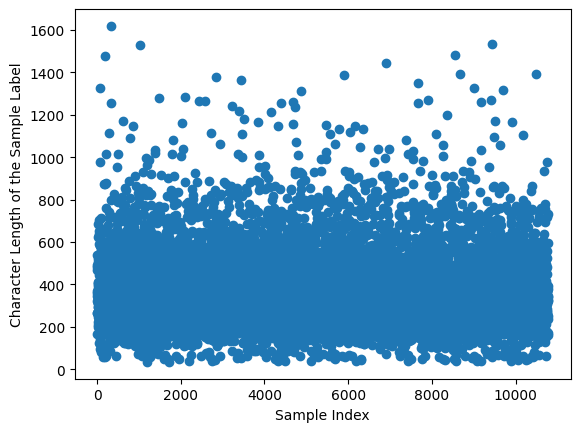

In [ ]:
#from looking at the distribution below, we can see that most of the labels fall within 1000 characters
#but the max generation token limit for this blip model is 512 characters (runtime warning if I set the token limit beyond 512 says that the model
#isn't suited for longer lengths and I may see degraded performance)

plt.scatter(np.arange(len(test_dataset.get_gt())), [len(ele) for ele in test_dataset.get_gt()])
plt.xlabel('Sample Index')
plt.ylabel('Character Length of the Sample Label')

In [ ]:
#to avoid unfairly penalizing the model during evaluation, I put in a section below to truncate the ground truth label to 500 tokens if need be
#for evaluation only. During training, model will still see the full length of the text as it does its forward pass etc.

In [ ]:
#setting up our optimizer with 5e-5 learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

#prep the datasets that will be used/seen during the training loop
name_datasets = ['train', 'val']
datasets = [train_dataloader_blip, val_dataloader_blip]

#set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

#initialize the metrics
best_wer = 0

#let's run a simple training loop
for epoch in range(2): #keeping the epoch numbers small because performance seemed far worse when we previously trained beyond a few epochs

  print("Epoch:", epoch)

  for name, data in zip(name_datasets, datasets):

    if name == 'train':
      model.train() #set model to training mode
    else:
      model.eval() #set model to eval mode


    #keep a higher level list of running metric values
    rwer = 0
    epoch_agg_metrics = {}

    for idx, batch in enumerate(tqdm.tqdm(data)):

      #get the specific pieces of information we need from each sample
      input_ids = batch.pop("input_ids").to(device)
      pixel_values = batch.pop("pixel_values").to(device)
      attention_mask = batch.pop("attention_mask").to(device)

      optimizer.zero_grad() #zero out the gradient

      with torch.set_grad_enabled(name == 'train'):

        #send the samples to the model
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids,
                        attention_mask=attention_mask)

        #get and print loss
        loss = outputs.loss
        print(f"{name} loss:", loss.item())

        #backprop
        if name == 'train':
          loss.backward()
          optimizer.step()

      #check how the current model at this stage of training fares on wer metrics
      generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=500)
      generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)
      gt_caption = processor.batch_decode([i[:500] for i in input_ids], skip_special_tokens=True)

      if idx % 100 == 0:
        print(f"This was the generated caption: {generated_caption}")
        print(f"This was the true caption: {gt_caption}")

      wer_score = wer.compute(predictions=generated_caption, references=gt_caption)
      rwer += wer_score

      #calculate the agg metrics for every 100 step interval
      if idx % 100 == 0:
        agg_wer = rwer/(idx+1)
        print(f"Step {idx+1} -- wer: {agg_wer}")

      #keep track of how well the model is doing on wer
      if name == 'val' and idx%1000 == 0:
        if agg_wer > best_wer:
          best_wer = agg_wer
          best_model_wts_wer = copy.deepcopy(model.state_dict())
          torch.save(best_model_wts_wer, 'drive/MyDrive/fine_tuned_blip_wer_WEIGHTS_ONLY')

print(f"BEST WER: {best_wer}")

Epoch: 0


  0%|          | 0/16165 [00:00<?, ?it/s]

train loss: 6.785060882568359


  0%|          | 1/16165 [00:01<8:13:39,  1.83s/it]

This was the generated caption: ['there are many birds sitting on a wire with music notes', 'arafed wire with birds sitting on it']
This was the true caption: ['* * ekern _ 1. 0 < t > * * ekern _ 1. 0 < b > * cleff4 < t > * clefg2 < b > * k [ b - ] < t > * k [ b - ] < b > * m3 / 4 < t > * m3 / 4 < b > = - < t > = - < b > 4cc < t > 8. ddl < b >. < t > 16ccjk < b > 4c < s > 4e < s > 4b - < t > 4b - < b > 4c < s > 4e < s > 4b - < t > 8al < b >. < t > 8gj < b > = < t > = < b > 4ff < t > 8fl < b >. < t > 8gj < b > 4c < s > 4f < s > 4a < t > 4a < b > 4c < s > 4f < s > 4a < t > 8al < b >. < t > 8b - j < b > = < t > = < b > 4cc < t > 8ddl < b >. < t > 16r < b >. < t > 16ccjk < b > 4c < s > 4e < s > 4b - < t > 4b - < b > 4c < s > 4e < s > 4b - < t > 8al < b >. < t > 8gj < b > = < t > = < b > * ^ < t > * < b > 4ff < < t > 4r < t > 8fl < b >. < t >. < t > 8gj < b > 4f < s > 4a < t > 8cl < t > 2a < b >. < t > 8c # j < t >. < b > 4r < t > 4d < s > 4f < s > 4a < t >. < b > * v < t > * v < t > * < b 

  0%|          | 2/16165 [00:03<8:11:10,  1.82s/it]

train loss: 6.565906524658203


  0%|          | 3/16165 [00:05<8:05:50,  1.80s/it]

train loss: 5.567357063293457


  0%|          | 4/16165 [00:07<8:09:52,  1.82s/it]

train loss: 6.604998588562012


  0%|          | 5/16165 [00:09<8:13:59,  1.83s/it]

train loss: 5.291231155395508


  0%|          | 6/16165 [00:10<8:12:16,  1.83s/it]

train loss: 5.168936729431152


  0%|          | 7/16165 [00:12<8:13:14,  1.83s/it]

train loss: 5.511659622192383


  0%|          | 8/16165 [00:14<8:13:35,  1.83s/it]

train loss: 4.920980453491211


  0%|          | 9/16165 [00:16<8:12:47,  1.83s/it]

train loss: 4.43996000289917


  0%|          | 10/16165 [00:18<8:12:35,  1.83s/it]

train loss: 4.05305290222168


  0%|          | 11/16165 [00:20<8:13:11,  1.83s/it]

train loss: 4.8976874351501465


  0%|          | 12/16165 [00:21<8:12:05,  1.83s/it]

train loss: 4.694485664367676


  0%|          | 13/16165 [00:23<8:11:04,  1.82s/it]

train loss: 4.11912202835083


  0%|          | 14/16165 [00:25<8:11:38,  1.83s/it]

train loss: 4.386322021484375


  0%|          | 15/16165 [00:27<8:14:27,  1.84s/it]

train loss: 7.187243461608887


  0%|          | 16/16165 [00:29<8:17:54,  1.85s/it]

train loss: 5.810055732727051


  0%|          | 17/16165 [00:31<8:20:42,  1.86s/it]

train loss: 3.824472188949585


  0%|          | 18/16165 [00:32<8:13:19,  1.83s/it]

train loss: 3.294266939163208


  0%|          | 19/16165 [00:34<8:08:21,  1.81s/it]

train loss: 3.881500244140625


  0%|          | 20/16165 [00:36<8:08:58,  1.82s/it]

train loss: 4.423997402191162


  0%|          | 21/16165 [00:38<8:09:48,  1.82s/it]

train loss: 3.69490909576416


  0%|          | 22/16165 [00:40<8:15:40,  1.84s/it]

train loss: 4.680509090423584


  0%|          | 23/16165 [00:42<8:17:52,  1.85s/it]

train loss: 3.910386562347412


  0%|          | 24/16165 [00:43<8:15:00,  1.84s/it]

train loss: 3.2180047035217285


  0%|          | 25/16165 [00:45<8:17:37,  1.85s/it]

train loss: 3.052232265472412


  0%|          | 26/16165 [00:47<8:20:34,  1.86s/it]

train loss: 3.3935508728027344


  0%|          | 27/16165 [00:49<8:15:25,  1.84s/it]

train loss: 3.4846038818359375


  0%|          | 28/16165 [00:51<8:11:23,  1.83s/it]

train loss: 3.227027654647827


  0%|          | 29/16165 [00:53<8:14:21,  1.84s/it]

train loss: 2.836740016937256


  0%|          | 30/16165 [00:55<8:16:32,  1.85s/it]

train loss: 2.9687929153442383


  0%|          | 31/16165 [00:56<8:13:33,  1.84s/it]

train loss: 3.7637314796447754


  0%|          | 32/16165 [00:58<8:11:10,  1.83s/it]

train loss: 2.8456239700317383


  0%|          | 33/16165 [01:00<8:12:53,  1.83s/it]

train loss: 3.324714183807373


  0%|          | 34/16165 [01:12<21:15:56,  4.75s/it]

train loss: 2.5086212158203125


  0%|          | 35/16165 [01:23<30:11:30,  6.74s/it]

train loss: 2.3986659049987793


  0%|          | 36/16165 [01:34<36:33:03,  8.16s/it]

train loss: 2.5228724479675293


  0%|          | 37/16165 [01:46<41:05:21,  9.17s/it]

train loss: 3.9952316284179688


  0%|          | 38/16165 [01:48<31:18:03,  6.99s/it]

train loss: 2.686800956726074


  0%|          | 39/16165 [01:50<24:27:45,  5.46s/it]

train loss: 2.8970258235931396


  0%|          | 40/16165 [01:52<19:37:16,  4.38s/it]

train loss: 2.2818715572357178


  0%|          | 41/16165 [02:03<29:15:00,  6.53s/it]

train loss: 2.1446077823638916


  0%|          | 42/16165 [02:15<35:57:34,  8.03s/it]

train loss: 2.179285764694214


  0%|          | 43/16165 [02:26<40:37:19,  9.07s/it]

train loss: 2.423391819000244


  0%|          | 44/16165 [02:38<43:50:16,  9.79s/it]

train loss: 1.9432594776153564


  0%|          | 45/16165 [02:49<46:04:26, 10.29s/it]

train loss: 3.2182183265686035


  0%|          | 46/16165 [02:51<34:42:12,  7.75s/it]

train loss: 2.52327299118042


  0%|          | 47/16165 [02:53<26:45:38,  5.98s/it]

train loss: 2.8417258262634277


  0%|          | 48/16165 [02:55<21:07:25,  4.72s/it]

train loss: 1.890350580215454


  0%|          | 49/16165 [02:56<17:10:45,  3.84s/it]

train loss: 2.3629534244537354


  0%|          | 50/16165 [02:58<14:30:39,  3.24s/it]

train loss: 2.0641233921051025


  0%|          | 51/16165 [03:00<12:37:40,  2.82s/it]

train loss: 3.091564416885376


  0%|          | 52/16165 [03:11<24:14:03,  5.41s/it]

train loss: 2.1313843727111816


  0%|          | 53/16165 [03:13<19:20:53,  4.32s/it]

train loss: 2.2723867893218994


  0%|          | 54/16165 [03:15<15:58:04,  3.57s/it]

train loss: 2.035977363586426


  0%|          | 55/16165 [03:17<13:40:17,  3.06s/it]

train loss: 1.6723631620407104


  0%|          | 56/16165 [03:19<12:03:59,  2.70s/it]

train loss: 1.8318439722061157


  0%|          | 57/16165 [03:21<10:52:06,  2.43s/it]

train loss: 2.0938332080841064


  0%|          | 58/16165 [03:22<10:02:28,  2.24s/it]

train loss: 3.266624689102173


  0%|          | 59/16165 [03:24<9:27:01,  2.11s/it] 

train loss: 1.7110854387283325


  0%|          | 60/16165 [03:26<9:07:48,  2.04s/it]

train loss: 1.8245793581008911


  0%|          | 61/16165 [03:28<8:52:20,  1.98s/it]

train loss: 1.7319635152816772


  0%|          | 62/16165 [03:30<8:41:08,  1.94s/it]

train loss: 1.5398319959640503


  0%|          | 63/16165 [03:32<8:33:28,  1.91s/it]

train loss: 1.9368301630020142


  0%|          | 64/16165 [03:33<8:24:57,  1.88s/it]

train loss: 1.9492976665496826


  0%|          | 65/16165 [03:35<8:19:22,  1.86s/it]

train loss: 1.6573718786239624


  0%|          | 66/16165 [03:37<8:13:10,  1.84s/it]

train loss: 1.8093254566192627


  0%|          | 67/16165 [03:39<8:09:38,  1.82s/it]

train loss: 1.6470898389816284


  0%|          | 68/16165 [03:41<8:08:00,  1.82s/it]

train loss: 1.6058018207550049


  0%|          | 69/16165 [03:42<8:06:34,  1.81s/it]

train loss: 1.704673171043396


  0%|          | 70/16165 [03:44<8:06:16,  1.81s/it]

train loss: 2.0907840728759766


  0%|          | 71/16165 [03:46<8:04:45,  1.81s/it]

train loss: 1.7495744228363037


  0%|          | 72/16165 [03:48<8:04:47,  1.81s/it]

train loss: 1.6342225074768066


  0%|          | 73/16165 [03:50<8:03:55,  1.80s/it]

train loss: 1.7480543851852417


  0%|          | 74/16165 [03:51<8:02:11,  1.80s/it]

train loss: 1.6019563674926758


  0%|          | 75/16165 [03:53<8:03:52,  1.80s/it]

train loss: 1.5597256422042847


  0%|          | 76/16165 [03:55<8:03:59,  1.80s/it]

train loss: 1.6267222166061401


  0%|          | 77/16165 [04:07<21:04:10,  4.71s/it]

train loss: 1.60991370677948


  0%|          | 78/16165 [04:18<30:10:20,  6.75s/it]

train loss: 1.4873415231704712


  0%|          | 79/16165 [04:30<36:29:23,  8.17s/it]

train loss: 1.671089768409729


  0%|          | 80/16165 [04:41<40:56:06,  9.16s/it]

train loss: 1.7359634637832642


  1%|          | 81/16165 [04:53<44:06:52,  9.87s/it]

train loss: 1.5214803218841553


  1%|          | 82/16165 [05:04<46:18:26, 10.37s/it]

train loss: 1.4153013229370117


  1%|          | 83/16165 [05:16<47:50:41, 10.71s/it]

train loss: 1.906777262687683


  1%|          | 84/16165 [05:27<48:54:42, 10.95s/it]

train loss: 1.4221693277359009


  1%|          | 85/16165 [05:39<49:41:28, 11.12s/it]

train loss: 1.5409469604492188


  1%|          | 86/16165 [05:50<50:13:29, 11.25s/it]

train loss: 1.4928981065750122


  1%|          | 87/16165 [06:02<50:34:46, 11.33s/it]

train loss: 1.300754427909851


  1%|          | 88/16165 [06:13<50:50:07, 11.38s/it]

train loss: 1.8629893064498901


  1%|          | 89/16165 [06:25<50:58:41, 11.42s/it]

train loss: 1.6547787189483643


  1%|          | 90/16165 [06:36<51:03:48, 11.44s/it]

train loss: 1.845826506614685


  1%|          | 91/16165 [06:48<51:07:45, 11.45s/it]

train loss: 1.2426567077636719


  1%|          | 92/16165 [06:59<51:12:27, 11.47s/it]

train loss: 1.472185730934143


  1%|          | 93/16165 [07:11<51:15:18, 11.48s/it]

train loss: 1.507523536682129


  1%|          | 94/16165 [07:22<51:12:26, 11.47s/it]

train loss: 1.4616868495941162


  1%|          | 95/16165 [07:34<51:15:15, 11.48s/it]

train loss: 1.452836275100708


  1%|          | 96/16165 [07:45<51:17:26, 11.49s/it]

train loss: 1.4268378019332886


  1%|          | 97/16165 [07:57<51:20:05, 11.50s/it]

train loss: 1.5799334049224854


  1%|          | 98/16165 [08:08<51:19:57, 11.50s/it]

train loss: 1.4366884231567383


  1%|          | 99/16165 [08:20<51:22:18, 11.51s/it]

train loss: 1.478736400604248


  1%|          | 100/16165 [08:31<51:22:19, 11.51s/it]

train loss: 1.411198616027832


  1%|          | 101/16165 [08:43<51:20:06, 11.50s/it]

This was the generated caption: ['* * ekern _ 1 * 0 < t > * * ekern _ 1. 0 < b > * cleff4 < t > * clefg2 < t > * k [ f * k [ f * k [ f * k [ f * k [ f * k [ f * k [ f * k [ f * k [ f * k [ f * k [ f * ] < t > * k [ f * g < t > * ] < t > * ] < t > * k [ f * ] < t > * g * g * k [ f * g * g * < t > * g * k [ f * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * < t > * < t > * g * g * g * g * g * g * g * g * g * g * g * g * g * g * < t > * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * g * < t > * g * g * g * g * < t > * g * g * g * < t > * < t > * g * g * g * g * g * g * g * < t > * < t > * g * < t > * g * g * g * g * < t > * g * g * < t > * g * < t > * < t > * g * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t > * < t >

  1%|          | 102/16165 [08:54<51:20:09, 11.51s/it]

train loss: 1.2774980068206787


  1%|          | 103/16165 [09:06<51:18:16, 11.50s/it]

train loss: 1.3346627950668335


  1%|          | 104/16165 [09:17<51:20:42, 11.51s/it]

train loss: 1.282429814338684


  1%|          | 105/16165 [09:29<51:20:26, 11.51s/it]

train loss: 1.4645605087280273


  1%|          | 106/16165 [09:40<51:18:28, 11.50s/it]

train loss: 1.4098286628723145


  1%|          | 107/16165 [09:52<51:15:27, 11.49s/it]

train loss: 1.346493124961853


  1%|          | 108/16165 [10:03<51:15:07, 11.49s/it]

train loss: 1.2513110637664795


  1%|          | 109/16165 [10:15<51:14:40, 11.49s/it]

train loss: 1.4049180746078491


  1%|          | 110/16165 [10:26<51:14:12, 11.49s/it]

train loss: 1.3986362218856812


  1%|          | 111/16165 [10:38<51:14:02, 11.49s/it]

train loss: 1.2847589254379272


  1%|          | 112/16165 [10:49<51:12:42, 11.48s/it]

train loss: 1.58637535572052


  1%|          | 113/16165 [11:01<51:11:41, 11.48s/it]

train loss: 1.4530786275863647


  1%|          | 114/16165 [11:12<51:10:06, 11.48s/it]

train loss: 1.1805167198181152


  1%|          | 115/16165 [11:23<51:08:51, 11.47s/it]

train loss: 1.7371546030044556


  1%|          | 116/16165 [11:35<51:08:17, 11.47s/it]

train loss: 1.510024070739746


  1%|          | 117/16165 [11:46<51:07:58, 11.47s/it]

train loss: 1.336954116821289


  1%|          | 118/16165 [11:58<51:07:18, 11.47s/it]

train loss: 1.2291557788848877


  1%|          | 119/16165 [12:09<51:08:19, 11.47s/it]

train loss: 1.2627068758010864


  1%|          | 120/16165 [12:21<51:07:57, 11.47s/it]

train loss: 1.352950096130371


  1%|          | 121/16165 [12:32<51:08:46, 11.48s/it]

train loss: 1.236096978187561


  1%|          | 122/16165 [12:44<51:08:17, 11.48s/it]

train loss: 1.329064965248108


  1%|          | 123/16165 [12:55<51:07:31, 11.47s/it]

train loss: 1.345861554145813


  1%|          | 124/16165 [13:07<51:06:47, 11.47s/it]

train loss: 1.414306879043579


  1%|          | 125/16165 [13:18<51:07:29, 11.47s/it]

train loss: 1.2459750175476074


  1%|          | 126/16165 [13:30<51:08:07, 11.48s/it]

train loss: 1.553471326828003


  1%|          | 127/16165 [13:41<51:12:11, 11.49s/it]

train loss: 1.3085546493530273


  1%|          | 128/16165 [13:53<51:14:55, 11.50s/it]

train loss: 1.3389090299606323


  1%|          | 129/16165 [14:04<51:13:42, 11.50s/it]

train loss: 1.2377700805664062


  1%|          | 130/16165 [14:16<51:13:58, 11.50s/it]

train loss: 1.414342999458313


  1%|          | 131/16165 [14:27<51:14:27, 11.50s/it]

train loss: 1.4466837644577026


  1%|          | 132/16165 [14:39<51:16:10, 11.51s/it]

train loss: 1.302763819694519


  1%|          | 133/16165 [14:50<51:14:14, 11.51s/it]

train loss: 1.2456114292144775


  1%|          | 134/16165 [15:02<51:16:07, 11.51s/it]

train loss: 1.2949347496032715


  1%|          | 135/16165 [15:13<51:14:03, 11.51s/it]

train loss: 1.2936718463897705


  1%|          | 136/16165 [15:25<51:12:49, 11.50s/it]

train loss: 1.1797266006469727


  1%|          | 137/16165 [15:36<51:13:05, 11.50s/it]

train loss: 1.2363743782043457


  1%|          | 138/16165 [15:48<51:13:11, 11.51s/it]

train loss: 1.3926244974136353


  1%|          | 139/16165 [15:59<51:14:24, 11.51s/it]

train loss: 1.2701929807662964


  1%|          | 140/16165 [16:11<51:11:17, 11.50s/it]

train loss: 1.177018165588379


  1%|          | 141/16165 [16:22<51:13:59, 11.51s/it]

train loss: 1.2385213375091553


  1%|          | 142/16165 [16:34<51:13:53, 11.51s/it]

train loss: 1.2808016538619995


  1%|          | 143/16165 [16:45<51:13:02, 11.51s/it]

train loss: 1.191558599472046


  1%|          | 144/16165 [16:57<51:14:14, 11.51s/it]

train loss: 1.22603440284729


  1%|          | 145/16165 [17:08<51:13:19, 11.51s/it]

train loss: 1.1429390907287598


  1%|          | 146/16165 [17:20<51:15:19, 11.52s/it]

train loss: 1.299393653869629


  1%|          | 147/16165 [17:31<51:11:14, 11.50s/it]

train loss: 1.2983863353729248


  1%|          | 148/16165 [17:43<51:08:01, 11.49s/it]

train loss: 1.1044694185256958


  1%|          | 149/16165 [17:54<51:07:09, 11.49s/it]

train loss: 1.130153775215149


  1%|          | 150/16165 [18:06<51:20:51, 11.54s/it]

train loss: 1.1724272966384888


  1%|          | 151/16165 [18:18<51:21:27, 11.55s/it]

train loss: 1.190872311592102


  1%|          | 152/16165 [18:29<51:17:17, 11.53s/it]

train loss: 1.0531201362609863


  1%|          | 153/16165 [18:41<51:13:59, 11.52s/it]

train loss: 1.1133413314819336


  1%|          | 154/16165 [18:52<51:11:26, 11.51s/it]

train loss: 1.235416293144226


  1%|          | 155/16165 [19:04<51:10:57, 11.51s/it]

train loss: 1.0119330883026123


  1%|          | 156/16165 [19:15<51:08:52, 11.50s/it]

train loss: 1.2120178937911987


  1%|          | 157/16165 [19:27<51:07:36, 11.50s/it]

train loss: 1.0886059999465942


  1%|          | 158/16165 [19:38<51:06:58, 11.50s/it]

train loss: 1.0553743839263916


  1%|          | 159/16165 [19:50<51:06:08, 11.49s/it]

train loss: 1.204396367073059


  1%|          | 160/16165 [20:01<51:05:15, 11.49s/it]

train loss: 1.0592732429504395


  1%|          | 161/16165 [20:13<51:09:48, 11.51s/it]

train loss: 1.1422297954559326


  1%|          | 162/16165 [20:24<51:15:03, 11.53s/it]

train loss: 1.1898399591445923


  1%|          | 163/16165 [20:36<51:17:09, 11.54s/it]

train loss: 1.0379115343093872


  1%|          | 164/16165 [20:47<51:16:21, 11.54s/it]

train loss: 1.0366129875183105


  1%|          | 165/16165 [20:59<51:24:07, 11.57s/it]

train loss: 1.2017405033111572


  1%|          | 166/16165 [21:10<51:26:00, 11.57s/it]

train loss: 1.207945466041565


  1%|          | 167/16165 [21:22<51:24:11, 11.57s/it]

train loss: 1.0332285165786743


  1%|          | 168/16165 [21:34<51:18:38, 11.55s/it]

train loss: 1.1726514101028442


  1%|          | 169/16165 [21:45<51:17:04, 11.54s/it]

train loss: 1.1108319759368896


  1%|          | 170/16165 [21:57<51:19:55, 11.55s/it]

train loss: 1.1846256256103516


  1%|          | 171/16165 [22:08<51:21:15, 11.56s/it]

train loss: 1.101175308227539


  1%|          | 172/16165 [22:20<51:34:10, 11.61s/it]

train loss: 1.1014795303344727


  1%|          | 173/16165 [22:32<51:34:49, 11.61s/it]

train loss: 1.024963617324829


  1%|          | 174/16165 [22:43<51:33:15, 11.61s/it]

train loss: 1.176780343055725


  1%|          | 175/16165 [22:55<52:14:55, 11.76s/it]

train loss: 1.1238194704055786


  1%|          | 176/16165 [23:07<52:31:04, 11.82s/it]

train loss: 1.1101021766662598


  1%|          | 177/16165 [23:19<52:19:12, 11.78s/it]

train loss: 1.0631252527236938


  1%|          | 178/16165 [23:30<52:02:41, 11.72s/it]

train loss: 1.2398301362991333


  1%|          | 179/16165 [23:42<51:50:56, 11.68s/it]

train loss: 1.329732894897461


  1%|          | 180/16165 [23:54<51:36:44, 11.62s/it]

train loss: 1.0501765012741089


  1%|          | 181/16165 [24:05<51:24:58, 11.58s/it]

train loss: 1.0510218143463135


  1%|          | 182/16165 [24:17<51:17:32, 11.55s/it]

train loss: 1.1235727071762085


  1%|          | 183/16165 [24:28<51:23:45, 11.58s/it]

train loss: 0.8601868748664856


  1%|          | 184/16165 [24:40<51:21:31, 11.57s/it]

train loss: 1.1207340955734253


  1%|          | 185/16165 [24:52<51:45:02, 11.66s/it]

train loss: 1.213465690612793


  1%|          | 186/16165 [25:03<51:58:41, 11.71s/it]

train loss: 0.9733908772468567


  1%|          | 187/16165 [25:15<51:50:50, 11.68s/it]

train loss: 1.1419981718063354


  1%|          | 188/16165 [25:27<51:38:15, 11.64s/it]

train loss: 1.2050844430923462


  1%|          | 189/16165 [25:38<51:46:24, 11.67s/it]

train loss: 0.9869406223297119


  1%|          | 190/16165 [25:50<51:36:47, 11.63s/it]

train loss: 1.053209662437439


  1%|          | 191/16165 [26:01<51:30:00, 11.61s/it]

train loss: 1.1133745908737183


  1%|          | 192/16165 [26:13<51:23:02, 11.58s/it]

train loss: 1.00644052028656


  1%|          | 193/16165 [26:24<51:17:28, 11.56s/it]

train loss: 0.9400385618209839


  1%|          | 194/16165 [26:36<51:12:40, 11.54s/it]

train loss: 1.0672733783721924


  1%|          | 195/16165 [26:47<51:08:24, 11.53s/it]

train loss: 1.067376971244812


  1%|          | 196/16165 [26:59<51:06:29, 11.52s/it]

train loss: 0.9564799666404724


  1%|          | 197/16165 [27:10<51:01:37, 11.50s/it]

train loss: 1.2743339538574219


  1%|          | 198/16165 [27:22<51:00:21, 11.50s/it]

train loss: 1.1365363597869873


  1%|          | 199/16165 [27:34<51:12:17, 11.55s/it]

train loss: 0.9430329203605652


  1%|          | 200/16165 [27:45<51:07:34, 11.53s/it]

train loss: 1.117624282836914


  1%|          | 201/16165 [27:56<51:02:10, 11.51s/it]

This was the generated caption: ['* * ekern _ 1. 0 < t > * * ekern _ 1. 0 < b > * cleff4 < t > * clefg2 < b > * k [ b - e - a - ] < t > * k [ b - ] < t > * m3 / 4 < t > * m3 / 4 < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t > = - < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >. < t >.', '* * ekern _ 1. 0 < t >

  1%|          | 202/16165 [28:08<50:58:13, 11.49s/it]

train loss: 1.0041110515594482


  1%|▏         | 203/16165 [28:19<50:57:15, 11.49s/it]

train loss: 1.0244061946868896


  1%|▏         | 204/16165 [28:31<50:55:31, 11.49s/it]

train loss: 1.0567632913589478


  1%|▏         | 205/16165 [28:42<50:54:05, 11.48s/it]

train loss: 1.0217633247375488


  1%|▏         | 206/16165 [28:54<50:50:50, 11.47s/it]

train loss: 1.1500898599624634


  1%|▏         | 207/16165 [29:05<50:50:05, 11.47s/it]

train loss: 1.1129792928695679


  1%|▏         | 208/16165 [29:17<50:48:09, 11.46s/it]

train loss: 1.1309643983840942


  1%|▏         | 209/16165 [29:28<50:48:18, 11.46s/it]

train loss: 0.9383618831634521


  1%|▏         | 210/16165 [29:40<50:47:01, 11.46s/it]

train loss: 0.9397245049476624


  1%|▏         | 211/16165 [29:51<50:46:05, 11.46s/it]

train loss: 1.1493059396743774


  1%|▏         | 212/16165 [30:03<50:46:36, 11.46s/it]

train loss: 0.9849404096603394


  1%|▏         | 213/16165 [30:14<50:46:54, 11.46s/it]

train loss: 1.0851322412490845


  1%|▏         | 214/16165 [30:25<50:47:07, 11.46s/it]

train loss: 1.0483537912368774


  1%|▏         | 215/16165 [30:37<50:47:08, 11.46s/it]

train loss: 0.984506368637085


  1%|▏         | 216/16165 [30:48<50:47:42, 11.47s/it]

train loss: 0.8961498141288757


  1%|▏         | 217/16165 [31:00<50:49:23, 11.47s/it]

train loss: 1.100547194480896


  1%|▏         | 218/16165 [31:11<50:48:43, 11.47s/it]

train loss: 0.8555433750152588


  1%|▏         | 219/16165 [31:23<50:52:25, 11.49s/it]

train loss: 1.220692753791809


  1%|▏         | 220/16165 [31:34<50:52:21, 11.49s/it]

train loss: 1.0985935926437378


  1%|▏         | 221/16165 [31:46<50:52:22, 11.49s/it]

train loss: 1.017150640487671


  1%|▏         | 222/16165 [31:57<50:52:35, 11.49s/it]

train loss: 1.065344214439392


  1%|▏         | 223/16165 [32:09<50:53:47, 11.49s/it]

train loss: 0.920652449131012


  1%|▏         | 224/16165 [32:20<50:56:00, 11.50s/it]

train loss: 1.1316008567810059


  1%|▏         | 225/16165 [32:32<50:57:36, 11.51s/it]

train loss: 0.9287078976631165


  1%|▏         | 226/16165 [32:43<50:55:38, 11.50s/it]

train loss: 1.0159804821014404


  1%|▏         | 227/16165 [32:55<50:54:09, 11.50s/it]

train loss: 0.9845919013023376


  1%|▏         | 228/16165 [33:06<50:54:55, 11.50s/it]

train loss: 0.9749624729156494


  1%|▏         | 229/16165 [33:18<50:53:24, 11.50s/it]

train loss: 1.014125943183899


  1%|▏         | 230/16165 [33:29<50:52:31, 11.49s/it]

train loss: 0.9126140475273132


  1%|▏         | 231/16165 [33:41<50:51:14, 11.49s/it]

train loss: 1.0262681245803833


  1%|▏         | 232/16165 [33:52<50:52:11, 11.49s/it]

train loss: 0.9497554302215576


  1%|▏         | 233/16165 [34:04<50:51:45, 11.49s/it]

train loss: 1.0313963890075684


  1%|▏         | 234/16165 [34:15<50:51:33, 11.49s/it]

train loss: 1.0247355699539185


  1%|▏         | 235/16165 [34:27<50:51:11, 11.49s/it]

train loss: 1.0228140354156494


  1%|▏         | 236/16165 [34:38<50:50:29, 11.49s/it]

train loss: 0.9720300436019897


  1%|▏         | 237/16165 [34:50<50:51:12, 11.49s/it]

train loss: 0.996263325214386


  1%|▏         | 238/16165 [35:01<50:51:42, 11.50s/it]

train loss: 1.0791693925857544


  1%|▏         | 239/16165 [35:13<50:52:54, 11.50s/it]

train loss: 1.0513793230056763


  1%|▏         | 240/16165 [35:24<50:53:31, 11.50s/it]

train loss: 0.9164827466011047


  1%|▏         | 241/16165 [35:36<50:51:39, 11.50s/it]

train loss: 1.1042430400848389


  1%|▏         | 242/16165 [35:47<50:50:28, 11.49s/it]

train loss: 1.0477560758590698


  2%|▏         | 243/16165 [35:59<50:48:01, 11.49s/it]

train loss: 0.898464024066925


  2%|▏         | 244/16165 [36:10<50:47:42, 11.49s/it]

train loss: 1.0106923580169678


  2%|▏         | 245/16165 [36:22<50:46:48, 11.48s/it]

train loss: 1.0158859491348267


  2%|▏         | 246/16165 [36:33<50:46:52, 11.48s/it]

train loss: 0.875169038772583


  2%|▏         | 247/16165 [36:45<50:46:59, 11.49s/it]

train loss: 0.8453649878501892


  2%|▏         | 248/16165 [36:56<50:46:46, 11.48s/it]

train loss: 1.047399640083313


  2%|▏         | 249/16165 [37:08<50:46:46, 11.49s/it]

train loss: 0.9300259351730347


  2%|▏         | 250/16165 [37:19<50:46:47, 11.49s/it]

train loss: 0.9363964796066284


  2%|▏         | 251/16165 [37:31<50:45:30, 11.48s/it]

train loss: 1.0323035717010498


  2%|▏         | 252/16165 [37:42<50:44:24, 11.48s/it]

train loss: 0.9609911441802979


  2%|▏         | 253/16165 [37:54<50:42:53, 11.47s/it]

train loss: 0.9790931940078735


  2%|▏         | 254/16165 [38:05<50:43:45, 11.48s/it]

train loss: 0.9920989871025085


  2%|▏         | 255/16165 [38:17<50:42:31, 11.47s/it]

train loss: 1.0766210556030273


  2%|▏         | 256/16165 [38:28<50:42:55, 11.48s/it]

train loss: 0.8157442212104797


  2%|▏         | 257/16165 [38:39<50:43:50, 11.48s/it]

train loss: 0.8724854588508606


  2%|▏         | 258/16165 [38:51<50:42:48, 11.48s/it]

train loss: 0.8949875235557556


  2%|▏         | 259/16165 [39:02<50:41:38, 11.47s/it]

train loss: 1.1909263134002686


  2%|▏         | 260/16165 [39:14<50:42:20, 11.48s/it]

train loss: 1.121341347694397


  2%|▏         | 261/16165 [39:25<50:42:40, 11.48s/it]

train loss: 1.0033013820648193


  2%|▏         | 262/16165 [39:37<50:43:00, 11.48s/it]

train loss: 1.0109574794769287


  2%|▏         | 263/16165 [39:48<50:42:11, 11.48s/it]

train loss: 0.9631034731864929


  2%|▏         | 264/16165 [40:00<50:44:25, 11.49s/it]

train loss: 1.106876015663147


  2%|▏         | 265/16165 [40:11<50:47:17, 11.50s/it]

train loss: 1.0849391222000122


  2%|▏         | 266/16165 [40:23<50:52:25, 11.52s/it]

train loss: 0.8925009965896606


  2%|▏         | 267/16165 [40:35<50:54:09, 11.53s/it]

train loss: 1.2311139106750488


  2%|▏         | 268/16165 [40:46<50:55:35, 11.53s/it]

train loss: 1.0158977508544922


  2%|▏         | 269/16165 [40:58<50:55:30, 11.53s/it]

train loss: 0.8514686226844788


  2%|▏         | 270/16165 [41:09<50:54:07, 11.53s/it]

train loss: 1.1569963693618774


  2%|▏         | 271/16165 [41:21<50:52:14, 11.52s/it]

train loss: 0.9892265796661377


  2%|▏         | 272/16165 [41:32<50:50:35, 11.52s/it]

train loss: 0.8874739408493042


  2%|▏         | 273/16165 [41:44<50:49:20, 11.51s/it]

train loss: 0.8583935499191284


  2%|▏         | 274/16165 [41:55<50:47:30, 11.51s/it]

train loss: 1.0738155841827393


  2%|▏         | 275/16165 [42:07<50:49:04, 11.51s/it]

train loss: 1.1006832122802734


  2%|▏         | 276/16165 [42:18<50:50:11, 11.52s/it]

train loss: 0.9945022463798523


  2%|▏         | 277/16165 [42:30<50:50:32, 11.52s/it]

train loss: 1.064387559890747


  2%|▏         | 278/16165 [42:41<50:50:43, 11.52s/it]

train loss: 0.6689918041229248


  2%|▏         | 279/16165 [42:53<50:50:30, 11.52s/it]

train loss: 1.0510791540145874


In [ ]:
#save the model in case the training was cancelled early (i.e. the save in the val phase did not trigger)
best_model_wts = copy.deepcopy(model.state_dict())
torch.save(best_model_wts, 'drive/MyDrive/fine_tuned_blip_early_stop_WEIGHTS_ONLY')

### Evaluation of Fine-Tuned BLIP

In [ ]:
#let's test out a few different metrics: the classic F1, Precision, Recall, Accuracy, and WER

#(while we previously tried and considered more traditional image captioning-specific metrics like Rouge-N and BLEU, they crucially didn't seem to care about the sequence in which ngrams appeared,
#which is a big part of our use case. I.e., if a prediction has all the same notes as the reference but in a different order, the effective musical score can actually be very different.)

In [ ]:
model.eval() # set the model to eval mode if it wasn't there already

all_gt_ids, all_gt_text = [], []
all_pred_ids, all_pred_text = [], []

rwer = 0

with torch.no_grad(): #not computing gradients while testing
  for idx, batch in enumerate(tqdm.tqdm(test_dataloader_blip)):

    #retrieve the image and gt labels
    pixel_values = batch.pop("pixel_values").to(device)
    labels = batch.pop("input_ids").to(device)

    #make prediction and get both the outputted ids and the text caption
    generated_ids = model.generate(pixel_values=pixel_values, max_new_tokens=500)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)

    #get the text of the labels
    gt_caption = processor.batch_decode([i[:500] for i in labels], skip_special_tokens=True)

    wer_score = wer.compute(predictions=generated_caption, references=gt_caption)
    rwer += wer_score

    if idx % 100 == 0:
      agg_wer = rwer/(idx+1)
      print(f"Step {idx+1} -- wer: {agg_wer}")

    #store the preds and gts for eval later
    for pred_ids, pred_cap, gt_ids, gt_cap in zip(generated_ids, generated_caption, labels, gt_caption):
      all_pred_ids.append(pred_ids)
      all_pred_text.append(pred_cap)
      all_gt_ids.append(gt_ids)
      all_gt_text.append(gt_cap)

  0%|          | 1/5388 [00:10<15:09:58, 10.14s/it]

Step 1 -- wer: 0.4876905041031653


  2%|▏         | 101/5388 [17:04<14:53:04, 10.14s/it]

Step 101 -- wer: 0.525872300855325


  4%|▎         | 201/5388 [33:59<14:37:11, 10.15s/it]

Step 201 -- wer: 0.517460402165259


  6%|▌         | 301/5388 [50:54<14:29:13, 10.25s/it]

Step 301 -- wer: 0.5181147357452052


  7%|▋         | 401/5388 [1:07:49<14:02:58, 10.14s/it]

Step 401 -- wer: 0.5178195334128892


  9%|▉         | 501/5388 [1:24:44<13:46:31, 10.15s/it]

Step 501 -- wer: 0.5169364526713545


 11%|█         | 601/5388 [1:41:40<13:29:55, 10.15s/it]

Step 601 -- wer: 0.5179550650919159


 13%|█▎        | 701/5388 [1:58:38<13:12:42, 10.15s/it]

Step 701 -- wer: 0.5183756035530726


 14%|█▍        | 745/5388 [2:06:12<13:06:35, 10.16s/it]


KeyboardInterrupt: 

In [ ]:
#saving the predictions and the gt labels bc a full test run takes over a day w/ the gpu i'm on.
with open('drive/MyDrive/all_pred_ids.pickle', 'wb') as output:
    pickle.dump(all_pred_ids, output)
with open('drive/MyDrive/all_pred_text.pickle', 'wb') as output:
    pickle.dump(all_pred_text, output)
with open('drive/MyDrive/all_gt_ids.pickle', 'wb') as output:
    pickle.dump(all_gt_ids, output)
with open('drive/MyDrive/all_gt_text.pickle', 'wb') as output:
    pickle.dump(all_gt_text, output)

## Set up Data for Model Training

In [ ]:
"""Note: In this section, we borrow/adapt code from https://github.com/multiscore/e2e-pianoform, the original source code from the authors that designed and created the raw dataset"""

'Note: In this section, we borrow/adapt code from https://github.com/multiscore/e2e-pianoform, the original source code from the authors that designed and created the raw dataset'

In [ ]:
#let's create a different adapation of the original collate function for the dataset

def batch_preparation_ctc2(data):
    print(data)
    images = [sample['pixel_values'] for sample in data]
    gt = [sample['labels'] for sample in data]

    max_image_width = max([img.shape[2] for img in images])
    max_image_height = max([img.shape[1] for img in images])

    #(batch size)x(1 channel for grayscale)x(max height, max width)
    X_train = torch.ones(size=[len(images), 3, max_image_height, max_image_width]) #padding = 1

    for i, img in enumerate(images):
        c, h, w = img.size()
        X_train[i, 0, :h, :w] = img #replace the ones with the actual image. let the unfiilled space remain as padding=1
        X_train[i, 1, :h, :w] = img #replace the ones with the actual image. let the unfiilled space remain as padding=1
        X_train[i, 2, :h, :w] = img #replace the ones with the actual image. let the unfiilled space remain as padding=1

    Y_train = torch.zeros(size=[len(gt),max_length]) #batch size x max seq length (padding=0)
    for i, seq in enumerate(gt):
        Y_train[i, 0:len(seq)] = torch.from_numpy(np.asarray([char for char in seq]))

    X_train = image_processor(X_train, return_tensors="pt")

    print(type(X_train), type(Y_train))

    return {"pixel_values": X_train, "labels": Y_train}

In [ ]:
#Let's try out DEIT, which is a distilled version of ViT
image_processor = AutoImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224", do_rescale=False)
model = AutoModelForImageClassification.from_pretrained("facebook/deit-tiny-patch16-224", label2id=w2i, id2label=i2w, ignore_mismatched_sizes=True)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 192]) in the checkpoint and torch.Size([188, 192]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([188]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#let's freeze the model params but change the last layer to fit our expected output classification size (i.e. number of classes to classify).
# for p in model.parameters():
#     p.requires_grad = False
# model.classifier = torch.nn.Linear(192, max_length)

In [ ]:
class ImageSequence(torch.nn.Module):
  '''
  Model that uses
  '''
  def __init__(self, vision_model, seq2seq_model, vision_feature_dim):

    super().__init__()

    #instantiate models
    self.vision_model = vision_model #model to be used as a feature extractor
    self.model = seq2seq_model #model that will take the extracted features as input

    layers = [nn.Linear(input_size, 64), nn.ReLU(), nn.Dropout(0.2), nn.Linear(64, 2)]
    self.clf = torch.nn.Sequential(*layers)

  def forward(self, data):






In [ ]:
#just checking that the model structure is as expected...
model = torch.nn.Sequential(*list(model.children())[:-1])

In [ ]:
#making sure the device is set to what we expect/want
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = model.to(device)

cuda


## LET THE TRAINING BEGIN!!

In [ ]:
#this is a standard accuracy metric computation from official hf documentation
# def compute_metrics(eval_pred):
#     print(eval_pred)
#     print(eval_pred.predictions.shape)
#     print(eval_pred.label_ids.shape)
#     print(dir(eval_pred))
#     """Computes accuracy on a batch of predictions"""
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return metric.compute(predictions=predictions, references=eval_pred.label_ids)

def compute_metrics(eval_pred):
    metric1 = load_metric("precision")
    metric2 = load_metric("recall")
    metric3 = load_metric("f1")

    logits, labels = eval_pred
    print(logits.shape, labels.shape)
    print(logits[0], labels[0])

    with open('drive/MyDrive/logits.npy', 'wb') as f:
      np.save(f, logits)
    with open('drive/MyDrive/labels.npy', 'wb') as f:
      np.save(f, labels)

    predictions = np.argmax(logits, axis=-1)
    precision = metric1.compute(predictions=predictions, references=labels)["precision"]
    recall = metric2.compute(predictions=predictions, references=labels)["recall"]
    recall = metric3.compute(predictions=predictions, references=labels)["recall"]

    return {"precision": precision, "recall": recall, "f1": f1}

In [ ]:
#let's try out these training arguments with deit
args = TrainingArguments(
    "deit_music_v1",
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    warmup_ratio=0.1,
    logging_steps=8,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False
    )

In [ ]:
#let's run our trainer
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    data_collator=batch_preparation_ctc2,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
# trainer.log_metrics("train", train_results.metrics)
# trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate 

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


(10777, 1716) (10777, 1716)
[-0.91477895  1.1723566  -0.5298359  ...  0.4380668   1.448983
  0.23775768] [185.  63. 185. ...   0.   0.   0.]


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

In [ ]:
trainer.predict(val_dataset)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub data rate 

(10777, 1716)
(10777, 1716)
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'inputs', 'label_ids', 'predictions']


TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=1, collate_fn=batch_preparation_ctc2)

In [ ]:
next(iter(val_dataloader))['labels'].shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



torch.Size([1, 1716])

In [ ]:
metric_test = load_metric("recall")

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
print(metric_test.inputs_description)


Args:
- **predictions** (`list` of `int`): The predicted labels.
- **references** (`list` of `int`): The ground truth labels.
- **labels** (`list` of `int`): The set of labels to include when `average` is not set to `binary`, and their order when average is `None`. Labels present in the data can be excluded in this input, for example to calculate a multiclass average ignoring a majority negative class, while labels not present in the data will result in 0 components in a macro average. For multilabel targets, labels are column indices. By default, all labels in y_true and y_pred are used in sorted order. Defaults to None.
- **pos_label** (`int`): The class label to use as the 'positive class' when calculating the recall. Defaults to `1`.
- **average** (`string`): This parameter is required for multiclass/multilabel targets. If None, the scores for each class are returned. Otherwise, this determines the type of averaging performed on the data. Defaults to `'binary'`.
    - `'binary'`: 

In [ ]:
import numpy as np

labels = np.load('drive/MyDrive/labels.npy')
logits = np.load('drive/MyDrive/logits.npy')

In [ ]:
labels.shape

(10777, 1716)

In [ ]:
predictions = np.argmax(logits, axis=-1)

In [ ]:
predictions.shape

(10777,)

In [ ]:
len(val_dataset.get_gt())

10777

In [ ]:
val_dataset

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-base")
model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:171: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on google-t5/t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
model.encoder

T5Stack(
  (embed_tokens): Embedding(32128, 768)
  (block): ModuleList(
    (0): T5Block(
      (layer): ModuleList(
        (0): T5LayerSelfAttention(
          (SelfAttention): T5Attention(
            (q): Linear(in_features=768, out_features=768, bias=False)
            (k): Linear(in_features=768, out_features=768, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (o): Linear(in_features=768, out_features=768, bias=False)
            (relative_attention_bias): Embedding(32, 12)
          )
          (layer_norm): T5LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): T5LayerFF(
          (DenseReluDense): T5DenseActDense(
            (wi): Linear(in_features=768, out_features=3072, bias=False)
            (wo): Linear(in_features=3072, out_features=768, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (act): ReLU()
          )
          (layer_norm): T5LayerNorm()
          (d

In [ ]:
#let's create a different adapation of the original collate function for the dataset

def batch_preparation_t5(data):
    images = [sample[0] for sample in data]
    gt = [sample[1] for sample in data]

    # max_img_length = max([len(img) for img in images])

    # #(batch size)x(1 channel for grayscale)x(max height, max width)
    # X_train = torch.empty(size=[len(images), max_img_length]) #padding = 1
    # X_train.fill_(-100)

    # for i, img in enumerate(images):
    #     dim = len(img)
    #     X_train[i, :dim] = img #replace the ones with the actual image. let the unfiilled space remain as padding=1
    #     X_train[i].to(torch.int64)

    # Y_train = torch.empty((len(gt),max_length)) #batch size x max seq length
    # Y_train.fill_(-100)

    # for i, seq in enumerate(gt):
    #     Y_train[i, 0:len(seq)] = torch.from_numpy(np.asarray([char for char in seq]))

    return {"pixel_values": images, "labels": gt}

In [ ]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# import torch

# tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
# model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

# # the following 2 hyperparameters are task-specific
# max_source_length = 512
# max_target_length = 128

# # Suppose we have the following 2 training examples:
# input_sequence_1 = "Welcome to NYC"
# output_sequence_1 = "Bienvenue à NYC"

# input_sequence_2 = "HuggingFace is a company"
# output_sequence_2 = "HuggingFace est une entreprise"

# # encode the inputs
# task_prefix = "translate English to French: "
# input_sequences = [input_sequence_1, input_sequence_2]

# encoding = tokenizer(
#     [task_prefix + sequence for sequence in input_sequences],
#     padding="longest",
#     max_length=max_source_length,
#     truncation=True,
#     return_tensors="pt",
# )

# input_ids, attention_mask = encoding.input_ids, encoding.attention_mask

# # encode the targets
# target_encoding = tokenizer(
#     [output_sequence_1, output_sequence_2],
#     padding="longest",
#     max_length=max_target_length,
#     truncation=True,
#     return_tensors="pt",
# )
# labels = target_encoding.input_ids

# # replace padding token id's of the labels by -100 so it's ignored by the loss
# labels[labels == tokenizer.pad_token_id] = -100

# # forward pass
# loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels).loss
# loss.item()

In [ ]:
# from transformers import T5Tokenizer, T5ForConditionalGeneration

# tokenizer = T5Tokenizer.from_pretrained("google-t5/t5-small")
# model = T5ForConditionalGeneration.from_pretrained("google-t5/t5-small")

# input_ids = tokenizer("translate English to German: The house is wonderful.", return_tensors="pt").input_ids
# outputs = model.generate(input_ids)
# print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
# # Load model directly
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# tokenizer = AutoTokenizer.from_pretrained("google-t5/t5-base")
# model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-base")

In [ ]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer

args = TrainingArguments(
    "drive/MyDrive",
    evaluation_strategy="steps",
    eval_steps=480,
    logging_strategy="steps",
    logging_steps=480,
    save_strategy="steps",
    save_steps=480,
    learning_rate=3e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    num_train_epochs=1,
    load_best_model_at_end=True
)

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=batch_preparation_t5
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



AttributeError: 'list' object has no attribute 'dtype'

# VIT+GPT2

In [ ]:
tokenizer(val_dataset[0][1])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [ ]:

from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
import torch
from PIL import Image

model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")


config.json:   0%|          | 0.00/4.61k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [ ]:
from transformers import default_data_collator

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    output_dir="drive/MyDrive",
    fp16=False
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset2,
    eval_dataset=val_dataset2,
    data_collator=batch_preparation_ctc2,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
trainer.train()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



<class 'transformers.image_processing_utils.BatchFeature'> <class 'torch.Tensor'>


AttributeError: 

In [ ]:
val_dataset[0][0].to(torch.int64)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])

In [ ]:
feature_extractor()

In [ ]:
class my_dataset(torch.utils.data.Dataset):
    '''
    make a dataset object
    '''
    def __init__(self, data):
        self.data=data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {'pixel_values': self.data[idx][0], 'labels': self.data[idx][1]}



In [ ]:
val_dataset2=my_dataset(val_dataset)
train_dataset2=my_dataset(train_dataset)

In [ ]:
type(val_dataset2

__main__.my_dataset

In [ ]:
  output_ids = model.generate(np.array(val_dataset[0]))

  preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
  preds = [pred.strip() for pred in preds]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.